In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
import pycbc
from scipy.interpolate import interp1d
import scipy.optimize as optimize
import sys
sys.path.append('/home/anirudh.nemmani/git_repos/teobresums/Python/')
import EOBRun_module
sys.path.append('/home/anirudh.nemmani/git_repos/gweat/src/')
import TEOBResumS_utils as ecc_gen
import eccentric_source as ecc_sou
from pesummary.io import read
sys.path.append('/home/anirudh.nemmani/git_repos/GWMAT/src/') # GWMAT module path
import py_lgw
lgw = py_lgw.lensed_wf_gen()

In [2]:
def match(wf1, wf2, f_low=20, f_high=1024, psd_path='/home/anirudh.nemmani/Projects/isolated-versus-strong/data/psd_aLIGO_O4high.txt'):
    flen= max(len(wf1), len(wf2))
    wf1.resize(flen)
    wf2.resize(flen)
    
    delta_f = wf1.delta_f
    psd = pycbc.psd.from_txt(psd_path, flen, delta_f, f_low, is_asd_file=False)
    return pycbc.filter.matchedfilter.match(wf1, wf2, psd=psd, low_frequency_cutoff=f_low, high_frequency_cutoff=f_high)

In [3]:
# Reading GW150914 parameters

gw150914 = read('/home/anirudh.nemmani/Projects/isolated-versus-strong/data/IGWN-GWTC2p1-v2-GW150914_095045_PEDataRelease_mixed_cosmo.h5') # Path to GWTC posterior samples
gw150914_result = gw150914.samples_dict['C01:IMRPhenomXPHM']
gw150914_pe_res = dict()
idx = np.argmax(gw150914_result['log_likelihood'])
for key in gw150914_result.keys():
            val = gw150914_result[key][idx]
            gw150914_pe_res[key] = np.float64(val)

2023-09-05  15:56:16 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2023-09-05  15:56:16 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2023-09-05  15:56:16 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default


In [4]:
# Converting j-frame to l-frame
# Tilts are taken to be zero which is default in GWMAT
spins = lgw.jframe_to_l0frame(gw150914_pe_res['mass_1'], gw150914_pe_res['mass_2'], 20, phi_ref=gw150914_pe_res['phase'], 
                             theta_jn = gw150914_pe_res['theta_jn'], phi_jl=gw150914_pe_res['phi_jl'],
                             a_1=gw150914_pe_res['a_1'], a_2=gw150914_pe_res['a_2'], phi_12 = gw150914_pe_res['phi_12'])

for keys in spins.keys():
    print('%s : %s'%(keys, spins[keys]))

inclination : 2.491015454676615
spin1x : -0.0
spin1y : 0.0
spin1z : 0.8608417198511092
spin2x : -0.0
spin2y : 0.0
spin2z : 0.7195088134379835


# Defining parameters for waveform generation

In [5]:
sampling_frequency = 4096
f_start = 8  # starting frequency of WF, i.e., (2,2) mode of the WF.
f_low = 20    # Lower frequency from where SNR will be computed. It should satisfy the condition, f_start <= f_low, for it to make sense.
f_ref = 20.
f_high = None
# df = 0.007768570860783086 
init_pars = dict(f_start=f_start, f_low=f_low, f_high=f_high, f_ref=f_ref, sample_rate=sampling_frequency, ifo_list=['H1','L1'], wf_approximant='IMRPhenomXPHM')

cbc_pars = dict(mass_1=gw150914_pe_res['mass_1'], mass_2=gw150914_pe_res['mass_2'], chi1z=0, chi2z=0, 
              inclination=spins['inclination'], coa_phase=gw150914_pe_res['phase'], polarization=gw150914_pe_res['psi'], ra=gw150914_pe_res['ra'], dec=gw150914_pe_res['dec'], 
              luminosity_distance=gw150914_pe_res['luminosity_distance'], trigger_time=gw150914_pe_res['geocent_time'],
              ecc=0.2)
#psd_pars = dict(Noise=False, gen_seed=10, psd_L1='O4')

prms = {**init_pars, **cbc_pars}#, **psd_pars
pars = ecc_gen.teobresums_pars_update(prms)

# Generating TEOBResumS waveform using GWEAT (It contains Tapering)

In [6]:
wfs_res = ecc_gen.sim_ecc_noisy_wf_gen_with_snr(**pars)

wfs_hp = wfs_res['pure_polarized_wfs']['hp']
wfs_hc = wfs_res['pure_polarized_wfs']['hc']

f_hp = wfs_hp.to_frequencyseries(delta_f=wfs_hp.delta_f)
f_hc = wfs_hc.to_frequencyseries(delta_f=wfs_hc.delta_f)

# Taking normal strain, interpolating the absolute value and the unwrapped phase of the waveform

In [7]:
frequency_vector = np.arange(0, 1024, 0.01)

In [8]:
strain_array_hp = np.array(f_hp, dtype=np.complex128)
strain_array_hc = np.array(f_hc, dtype=np.complex128)

In [9]:
# Absolute strain series
abs_hp = np.abs(strain_array_hp)
abs_hc = np.abs(strain_array_hc)

# Phase series
phase_hp = np.array(pycbc.waveform.utils.phase_from_frequencyseries(f_hp))
phase_hc = np.array(pycbc.waveform.utils.phase_from_frequencyseries(f_hc))

In [10]:
if_abs_hp = interp1d(f_hp.sample_frequencies[:], abs_hp[:], kind='linear')
if_abs_hc = interp1d(f_hc.sample_frequencies[:], abs_hc[:], kind='linear')

if_phase_hp = interp1d(f_hp.sample_frequencies[:], phase_hp[:], kind='linear')
if_phase_hc = interp1d(f_hc.sample_frequencies[:], phase_hc[:], kind='linear')

In [11]:
interpolated_abs_hp = np.concatenate(([0], if_abs_hp(frequency_vector[1:])))
interpolated_abs_hc = np.concatenate(([0], if_abs_hc(frequency_vector[1:])))

interpolated_phase_hp = np.concatenate(([0], if_phase_hp(frequency_vector[1:])))
interpolated_phase_hc = np.concatenate(([0], if_phase_hc(frequency_vector[1:])))

In [12]:
interpolated_hp = interpolated_abs_hp*np.exp(1j*interpolated_phase_hp)
interpolated_hc = interpolated_abs_hc*np.exp(1j*interpolated_phase_hc)

In [13]:
frequency_bounds = (frequency_vector >=frequency_vector[0]) * (frequency_vector <= frequency_vector[-1])
interpolated_hp *= frequency_bounds
interpolated_hc *= frequency_bounds

In [14]:
interpolated_pycbc_hp =  pycbc.types.frequencyseries.FrequencySeries(interpolated_hp, delta_f=0.01)
interpolated_pycbc_hc =  pycbc.types.frequencyseries.FrequencySeries(interpolated_hc, delta_f=0.01)

In [15]:
# Plotting Interpolated waveform
fig = plt.figure(figsize=(18, 6))
plt.subplots_adjust(wspace= 0.1, hspace= 0.25)

sub_figure_1 = fig.add_subplot(1,2,1)
sub_figure_1.loglog(interpolated_pycbc_hp.sample_frequencies, np.abs(interpolated_pycbc_hp), label=r'$h_{+}$')
sub_figure_1.loglog(interpolated_pycbc_hc.sample_frequencies, np.abs(interpolated_pycbc_hc), label=r'$h_{\times}$')
sub_figure_1.set_title(r'Interpolated Frequencies Series, absolute value plot')
sub_figure_1.set_xlabel(r'Frequency ($Hz$)')
sub_figure_1.set_xlim(20, 1024)
sub_figure_1.set_ylabel(r'$\mid h \mid$')
sub_figure_1.legend()

sub_figure_2 = fig.add_subplot(1,2,2)
sub_figure_2.plot(interpolated_pycbc_hp.sample_frequencies, np.angle(interpolated_pycbc_hp), label=r'$h_{+}$')
sub_figure_2.plot(interpolated_pycbc_hc.sample_frequencies, np.angle(interpolated_pycbc_hc), label=r'$h_{\times}$')
sub_figure_2.set_title(r'Interpolated Frequencies Series, phase plot')
sub_figure_2.set_xlabel(r'Frequency ($Hz$)')
sub_figure_2.set_xscale('log')
sub_figure_2.set_xlim(20, 1024)
sub_figure_2.set_ylabel(r'Phase')
sub_figure_2.legend()

plt.suptitle(r'Interpolated waveform using absolute and unwrapped phase series of non spinning GW150914 IMRPhenomXPHM waveform')

Text(0.5, 0.98, 'Interpolated waveform using absolute and unwrapped phase series of non spinning GW150914 IMRPhenomXPHM waveform')

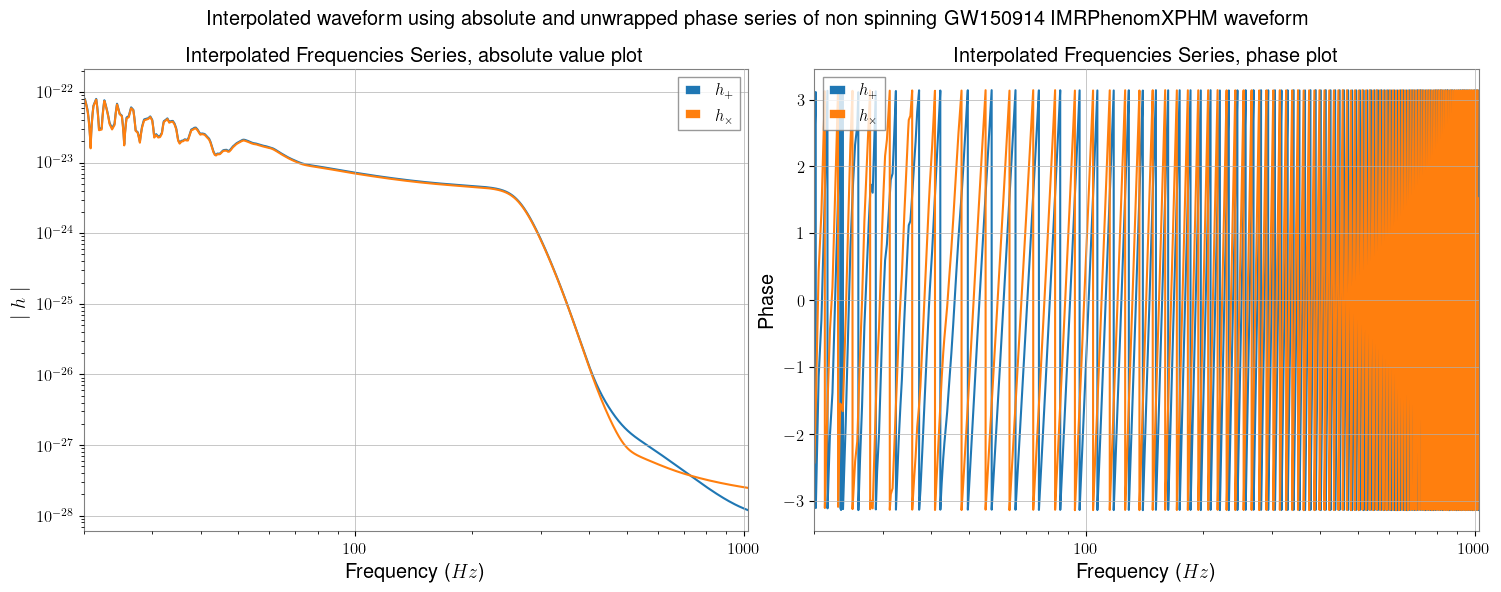

In [16]:
plt.show()

# Projecting on L1

In [17]:
from pycbc.detector import Detector
fp, fc = Detector('L1').antenna_pattern(pars['ra'], pars['dec'], pars['polarization'], pars['trigger_time'])

In [18]:
proj_interpolated_hp = fp*interpolated_pycbc_hp
proj_interpolated_hc = fc*interpolated_pycbc_hc
tot_proj_interpolated = proj_interpolated_hp + proj_interpolated_hc

In [19]:
fig = plt.figure(figsize=(18, 10))
# plt.subplots_adjust(wspace= 0.1, hspace= 0.25)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)

sub_figure_1 = fig.add_subplot(2,3,1)
sub_figure_1.loglog(proj_interpolated_hp.sample_frequencies, np.abs(proj_interpolated_hp), label=r'L1')
sub_figure_1.set_title(r'Plus Projection, $F_{+}h_{+}$')
sub_figure_1.set_xlabel(r'Frequency ($Hz$)')
sub_figure_1.set_xlim(20, 1024)
sub_figure_1.set_ylabel(r'$\mid h \mid$')
sub_figure_1.legend()
# sub_figure_1.text(x = 0, y = 0, s = r'\textbf{Absolute value plots}', rotation=90)

sub_figure_2 = fig.add_subplot(2,3,2)
sub_figure_2.loglog(proj_interpolated_hc.sample_frequencies, np.abs(proj_interpolated_hc), label=r'L1')
sub_figure_2.set_title(r'Cross Projection, $F_{\times}h_{\times}$')
sub_figure_2.set_xlabel(r'Frequency ($Hz$)')
sub_figure_2.set_xlim(20, 1024)
# sub_figure_2.set_ylabel(r'$\mid h \mid$')
sub_figure_2.legend()

sub_figure_3 = fig.add_subplot(2,3,3)
sub_figure_3.loglog(tot_proj_interpolated.sample_frequencies, np.abs(tot_proj_interpolated), label=r'L1')
sub_figure_3.set_title(r'Total Projection, $F_{+}h_{+} + F_{\times}h_{\times}$')
sub_figure_3.set_xlabel(r'Frequency ($Hz$)')
sub_figure_3.set_xlim(20, 1024)
# sub_figure_3.set_ylabel(r'$\mid h \mid$')
sub_figure_3.legend()

sub_figure_4 = fig.add_subplot(2,3,4)
sub_figure_4.plot(proj_interpolated_hp.sample_frequencies, np.angle(proj_interpolated_hp), label=r'L1')
sub_figure_4.set_title(r'Plus Projection, $F_{+}h_{+}$')
sub_figure_4.set_xlabel(r'Frequency ($Hz$)')
sub_figure_4.set_xscale('log')
sub_figure_4.set_xlim(20, 1024)
sub_figure_4.set_ylabel(r'Phase')
sub_figure_4.legend()
# sub_figure_4.text(x = 0, y = 0, s = r'\textbf{Phase value plots}', rotation=90)

sub_figure_5 = fig.add_subplot(2,3,5)
sub_figure_5.plot(proj_interpolated_hc.sample_frequencies, np.angle(proj_interpolated_hc), label=r'L1')
sub_figure_5.set_title(r'Cross Projection, $F_{\times}h_{\times}$')
sub_figure_5.set_xlabel(r'Frequency ($Hz$)')
sub_figure_5.set_xscale('log')
sub_figure_5.set_xlim(20, 1024)
# sub_figure_5.set_ylabel(r'Phase')
sub_figure_5.legend()

sub_figure_6 = fig.add_subplot(2,3,6)
sub_figure_6.plot(tot_proj_interpolated.sample_frequencies, np.angle(tot_proj_interpolated), label=r'L1')
sub_figure_6.set_title(r'Total Projection, $F_{+}h_{+} + F_{\times}h_{\times}$')
sub_figure_6.set_xlabel(r'Frequency ($Hz$)')
sub_figure_6.set_xscale('log')
sub_figure_6.set_xlim(20, 1024)
# sub_figure_6.set_ylabel(r'Phase')
sub_figure_6.legend()

plt.suptitle(r'Projection plots of non spinning GW150914 polar interpolated IMRPhenomXPHM')
plt.tight_layout

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

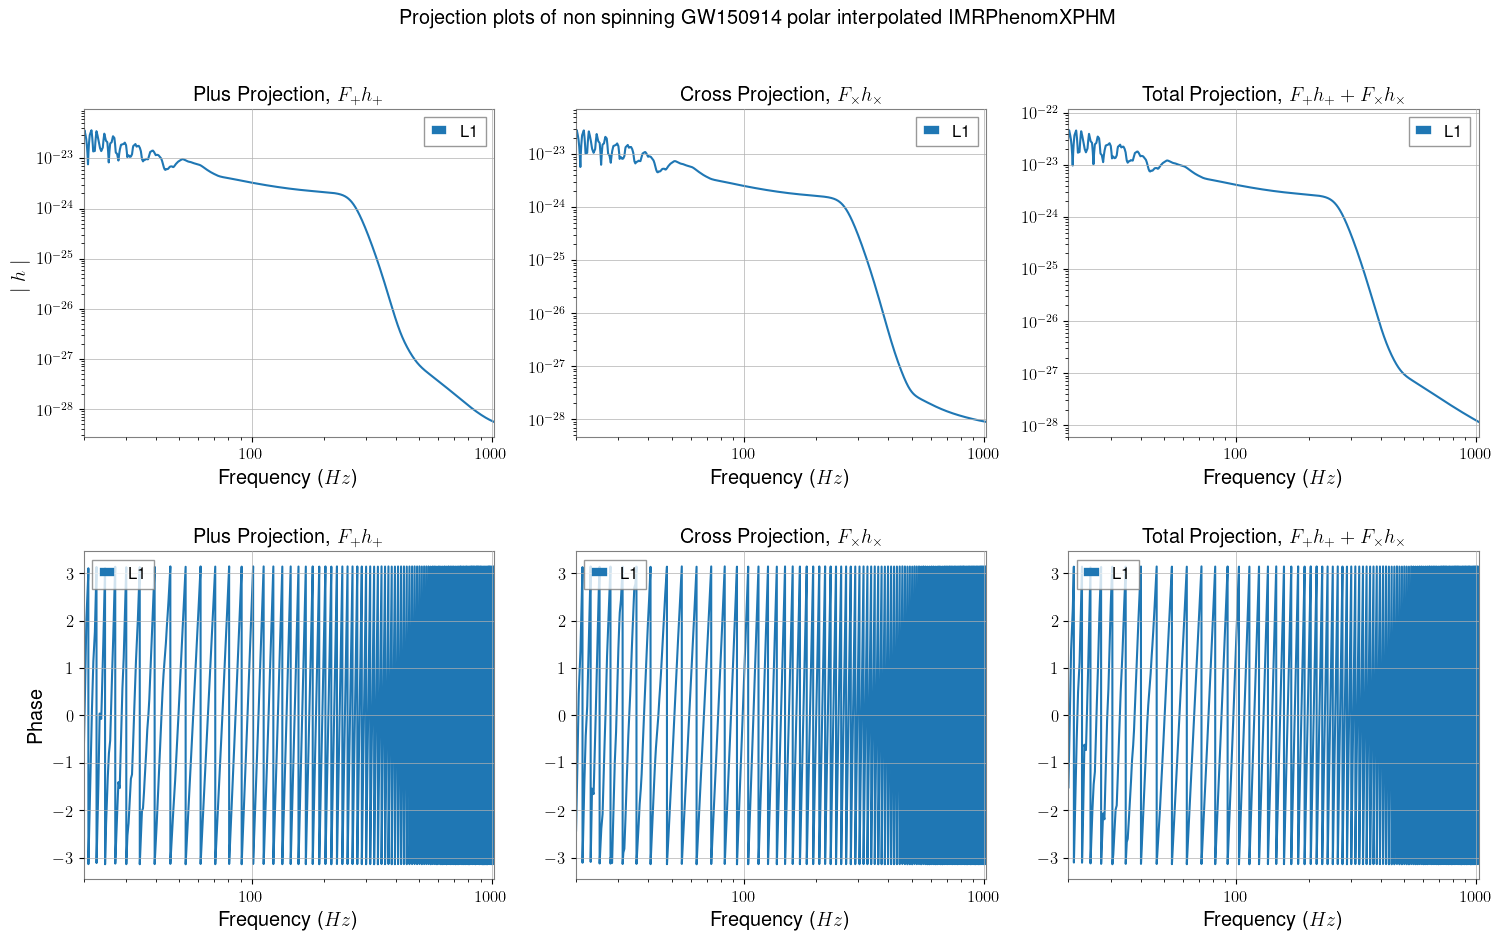

In [20]:
plt.show()

# Defining a function to get the interpolated frequency series for a given waveform

In [21]:
import numpy as np
import pycbc
from scipy.interpolate import interp1d

def interpolate_waveform(frequency_vector, return_pycbc_freq=False, **wfs_dict):
    """
    Interpolate waveform data using scipy's interp1d function.

    This interpolation is not done as a straightforward interpolation of the waveform;
    rather, the frequency series is broken down into absolute strain and unwrapped phase
    (polar coordinate frame) and then interpolated individually.

    The reason for interpolation in unwrapped phase is due to its linearity with frequency
    and is the best description of a waveform.

    :param frequency_vector: The frequency vector for interpolation.
    :param wfs_dict: A dictionary of waveform data.
    :param return_pycbc_freq: Whether to return the PyCBC FrequencySeries.
    :return: A dictionary of interpolated waveform data.
    """
    
    interpolated_dict = dict()
    for key in wfs_dict.keys():
        
        # Getting the strain data
        strain_array = np.array(wfs_dict[key], dtype=np.complex128)
        
        # Calculating the absolute value
        absolute = np.abs(strain_array)
        
        # Getting the unwrapped phase
        phase = np.array(pycbc.waveform.utils.phase_from_frequencyseries(wfs_dict[key]))
        
        # Generating the interpolation function
        if_abs = interp1d(wfs_dict[key].sample_frequencies[:], absolute[:], kind='linear')
        if_phase = interp1d(wfs_dict[key].sample_frequencies[:], phase[:], kind='linear')
        
        # Generating interpolated points based on the given frequency vector
        interpolated_abs = np.concatenate(([0], if_abs(frequency_vector[1:])))
        interpolated_phase = np.concatenate(([0], if_phase(frequency_vector[1:])))
        
        # Joining the absolute and phase values back to strain
        interpolated = interpolated_abs * np.exp(1j * interpolated_phase)
        
        # Applying boundary conditions of the frequency vector
        frequency_bounds = (frequency_vector >= frequency_vector[0]) * (frequency_vector <= frequency_vector[-1])
        interpolated *= frequency_bounds
        
        assert len(interpolated) == len(frequency_array), 'length mismatch between the required frequency array and TEOBResumS output'
        
        interpolated_dict[key] = interpolated
        
        if return_pycbc_freq:
            # Converting back into a frequency series
            df = frequency_vector[1] - frequency_vector[0]
            interpolated_pycbc = pycbc.types.frequencyseries.FrequencySeries(interpolated, delta_f=df)
            new_key = 'PyCBC_' + key
            interpolated_dict[new_key] = interpolated_pycbc
            
    return interpolated_dict